In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [3]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [4]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [5]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [13]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,rt_isotope_correlation,scan_isotope_correlation from features', db_conn)
db_conn.close()

In [14]:
sequences_df.sort_values(by='rt_isotope_correlation', ascending=False, inplace=True)

In [15]:
sequences_df.head(5)

,sequence,charge,file_idx,rt_isotope_correlation,scan_isotope_correlation
57501,DDGVFVQEVTQNSPAAR,2,7,1.0,1.000000
77413,DPYQEEEWPQGFGQLTK,2,3,1.0,-0.797713
488313,VLQSFTVDSSK,2,0,1.0,-1.000000
500392,VSQGVEDGPDTK,2,16,1.0,-0.129765
404559,SGCTNYLPTLITTSDELMK,2,6,1.0,0.000000


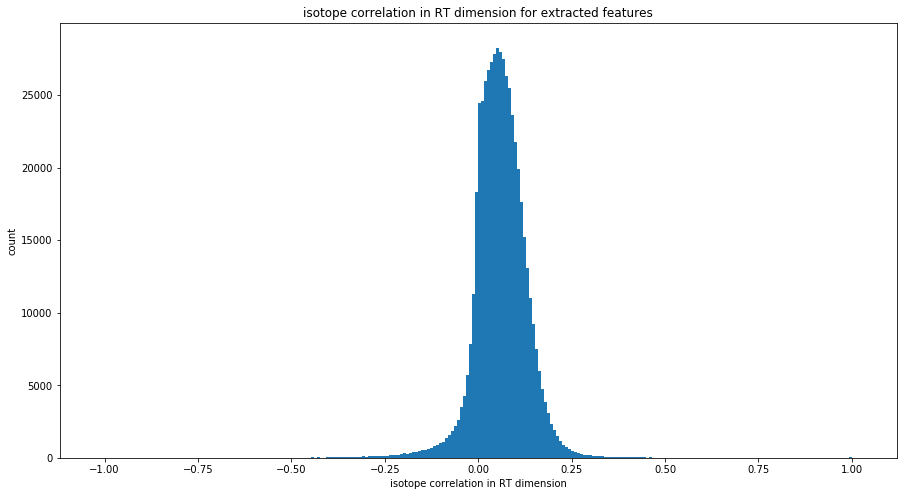

In [16]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_df.rt_isotope_correlation, bins=bins)
plt.xlabel('isotope correlation in RT dimension')
plt.ylabel('count')
plt.title('isotope correlation in RT dimension for extracted features')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

#### visualise isotopic correlation in raw points

In [18]:
selected_sequence = 'DDGVFVQEVTQNSPAAR'
selected_sequence_charge = 2
selected_sequence_file_idx = 7

In [42]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_s = pd.read_sql_query('select mono_filtered_points_l,isotope_1_filtered_points_l,isotope_2_filtered_points_l,mono_rt_bounds,isotope_1_rt_bounds,isotope_2_rt_bounds,isotope_intensities_l from features where sequence==\'{}\' and charge=={} and file_idx=={}'.format(selected_sequence,selected_sequence_charge,selected_sequence_file_idx), db_conn).iloc[0]
db_conn.close()

In [43]:
selected_sequence_s

mono_filtered_points_l         [{"x": 620.9879181523185, "filtered_intensity"...
isotope_1_filtered_points_l    [{"x": 620.9879181523185, "filtered_intensity"...
isotope_2_filtered_points_l    [{"x": 620.9879181523185, "filtered_intensity"...
mono_rt_bounds                            [648.3635047245427, 649.4272941057453]
isotope_1_rt_bounds                        [651.6068876971889, 653.276392627592]
isotope_2_rt_bounds                        [649.4272941057453, 653.276392627592]
isotope_intensities_l          [[23.0, false, 23.0, false, [[916.945630382901...
Name: 0, dtype: object

In [44]:
mono_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_filtered_points_l))
isotope_1_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_1_filtered_points_l))
isotope_2_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_2_filtered_points_l))    


In [45]:
mono_rt_lower,mono_rt_upper = json.loads(selected_sequence_s.mono_rt_bounds)
mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]

isotope_1_rt_lower,isotope_1_rt_upper = json.loads(selected_sequence_s.isotope_1_rt_bounds)
isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]

isotope_2_rt_lower,isotope_2_rt_upper = json.loads(selected_sequence_s.isotope_2_rt_bounds)
isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]


In [49]:
isotope_intensities_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_intensities_l), columns=['summed_intensity','saturated','inferred_intensity','inferred','isotope_points','isotope_apex_points'])

In [50]:
isotope_intensities_df

,summed_intensity,saturated,inferred_intensity,inferred,isotope_points,isotope_apex_points
0,23.0,False,23.0,False,"[[916.9456303829012, 320.0, 6086.0, 648.896332...","[[916.9456303829012, 320.0, 6086.0, 648.896332..."
1,368.0,False,368.0,False,"[[917.4442965545587, 312.0, 6086.0, 648.896332...","[[917.4442965545587, 366.0, 6086.0, 648.896332..."
2,140.0,False,140.0,False,"[[917.9478494306678, 309.0, 6086.0, 648.896332...","[[917.9478494306678, 380.0, 6086.0, 648.896332..."
3,115.0,False,115.0,False,"[[918.4467880135621, 354.0, 6086.0, 648.896332...","[[918.4467880135621, 364.0, 6086.0, 648.896332..."


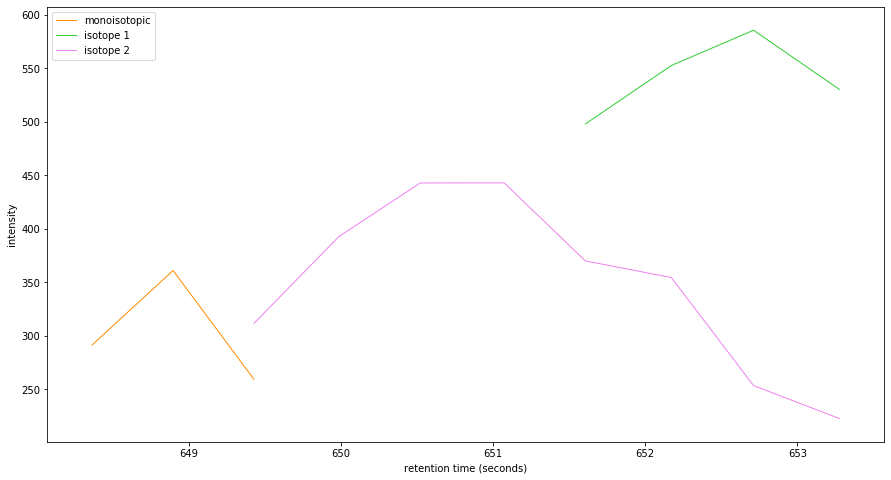

In [46]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

# title = 'maximum inferred intensity by monoisotopic mass'
# plt.title(title)

ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', lw=1, ms=30, alpha=1.0, label='monoisotopic')
ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='limegreen', linestyle='-', lw=1, ms=30, alpha=1.0, label='isotope 1')
ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='violet', linestyle='-', lw=1, ms=30, alpha=1.0, label='isotope 2')

for row in isotope_intensities_df.itertuples():
    isotope_df = 
    ax.scatter(isotope_df.retention_time_secs, isotope_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')    

plt.legend(loc='best')
plt.xlabel('retention time (seconds)')
plt.ylabel('intensity')

plt.show()